In [4]:
# inladen
# LOG OF CHANGES
# plotjes gefixt, laatste versie basically

import os
import sys
clear = lambda: os.system('cls')  # On Windows System
clear()
sys.path.insert(0, r'C:\Users\linda\Dropbox\TM\Stagedocumenten\Q2 2021-2022\IDA-model-main\IDA-model\Functions')
# Import the right data packages
import pandas as pd
import numpy as np
import seaborn as sns
from v1_baseline import baseline
from v1_drop_data import drop_data
from v1_feature_selection import find_sign_features
from v1_impute_data import impute_data
from v1_load_data import load_data
from v1_mean_ROC_curves import mean_ROC_curves
from v1_pipeline_model import pipeline_model
#from v4_pipeline_model import pipeline_model4
from v1_scale_data import scale_data
from v1_stratify import stratify
from v1_syndromen import syndromen
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
#from scipy.stats import mode
from scipy import stats
from statistics import mean
from statistics import stdev
from statistics import mode
# from statistics import mode
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from collections import Counter

# Load and merge data. Define paths and columns wanted from Excel files
path_data = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/v6_dataset.xlsx'
columns_data = "A:BBB"
path_labels = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/IDA_aangevuld.xls'
columns_labels = "A:B"
path_phecodes = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/phecodes_filled_binary.xlsx'
columns_phecodes = "A:R"
path_specialisms = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/Letters_DBC_combined.xlsx'
columns_specialisms = "A:BW"
path_decimals = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/afronden_features.xlsx'
columns_decimals = 'A:HI'
path_baseline = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/baseline.xlsx'
columns_baseline = 'A:C'
path_extra = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/v3_extra.xlsx'
columns_extra = 'A:D'
path_brieven = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/v2_brieven.xlsx'
columns_brieven = 'A:BR'
path_syndromen = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/v1_syndromen.xlsx'
columns_syndromen = 'A:B'
path_syndroomcodes = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/v1_syndroomcodes.xlsx'
columns_syndroomcodes = 'A:B'

# df data contains most of the features needed to build the model
df_data = load_data(path_data, columns_data)
# df labels contains the label ID/ no ID
df_labels = load_data(path_labels, columns_labels)
# df phecodes contains the data about the diagnoses a patient has, categorized into groups
df_phecodes = load_data(path_phecodes, columns_phecodes)
# df spec contains the data about what specialisms a patient visited
df_spec = load_data(path_specialisms, columns_specialisms)
# df decimal contains the amount of decimals for rounding the different features
df_decimal = load_data(path_decimals, columns_decimals)
# df baseline contains baseline characteristics age and gender
df_baseline = load_data(path_baseline, columns_baseline)
# df_extra contains extra characteristics like BMI and opnames
df_extra = load_data(path_extra, columns_extra)
# df_brieven contains the letters sent from specialisms
df_brieven = load_data(path_brieven,columns_brieven)
# df_syndromen contains the PIDs and syndrome code
df_syndromen = load_data(path_syndromen,columns_syndromen)
# df_syndroomcodes contains the syndrome code and syndrome names
df_syndroomcodes = load_data(path_syndroomcodes,columns_syndroomcodes)

# Merge dataframes
df_hix_spec = df_data.merge(df_spec, on='Pt_no', how='outer')
df_hix_phecodes = df_hix_spec.merge(df_phecodes, on='Pt_no', how='outer')
# In df hix, all features are merged inside one dataframe. The specialisms, phecodes and labels are added
df_hix = df_hix_phecodes.merge(df_labels, on='Pt_no', how='inner')
# Now add all the extra features
df_ex = df_hix.merge(df_extra, on='Pt_no',how = 'inner')
# Now add the letters from the specialisms
df_all = df_ex.merge(df_brieven, on = 'Pt_no', how = 'inner')
print('Number of columns before dropped columns: ' + str(len(df_all.columns)))

# Defining thresholds for dropping rows and columns with missing data (threshold of amount of non-NA values required)
threshold_column = 0.6
threshold_row = 0.5

# Drop columns and rows with too many NaN's
df_dropped = drop_data(threshold_column, threshold_row, df_all)
print('Number of columns after dropped columns: ' + str(len(df_dropped.columns)))

## Balance set by picking random samples from no ID group 
df_ID_1 = df_dropped.loc[df_dropped['Label'] == 1.0]
df_ID_0_all = df_dropped.loc[df_dropped['Label'] == 0.0]

# To perform stratified random sampling, the gender of the ID group is checked
# Merge the dataframes of ID and no ID with the baseline characteristics in df baseline (age and gender)
df_0_all_baseline = df_ID_0_all.merge(df_baseline, on='Pt_no', how='inner')
df_1_baseline = df_ID_1.merge(df_baseline, on='Pt_no', how='inner')
# Check baseline characteristics of subset
#characteristics = baseline(df_0_all_baseline, df_1_baseline)

# Stratify the data
df_control = stratify(df_0_all_baseline, df_1_baseline)
# Check baseline characteristics again after stratifying
# characteristics_stratified = baseline(df_control, df_1_baseline)

# Even voor het verslag: mean en std van de groepen
age_ID_mean = np.nanmean(df_1_baseline['Leeftijd'])
# age_ID_std = np.nanstd(df_1_baseline['Leeftijd'])
# print(f'leeftijd ID mean: {age_ID_mean}')
# print(f'leeftijd ID std {age_ID_std}')
# age_0_mean = np.nanmean(df_control['Leeftijd'])
# age_0_std = np.nanstd(df_control['Leeftijd'])
# print(f'leeftijd 0 mean: {age_0_mean}')
# print(f'leeftijd 0 std {age_0_std}')

# Merge the dataframes from ID and no ID again
df_comb = pd.concat([df_1_baseline,df_control])
df_comb = df_comb.drop(['Leeftijd', 'Geslacht'], axis = 1 )


Number of columns before dropped columns: 1569
Number of columns after dropped columns: 205


In [5]:
import matplotlib.pyplot as plt
 
def syndromen(df_syndromen, df_control, df_vb, df_syndroomcodes):

    # Syndromen bekijken
    # nu nog beter plotten en in een functie gooien
    # Controle groep
    # eerst even alle missings veranderen naar 0
    df_syndromen = df_syndromen.fillna(0)

    syndroom_control = []
    for pt in df_control['Pt_no']:
        slice = df_syndromen.loc[df_syndromen['Pt_no'] == pt]    # Fill dataframe with p-values
        syndroom = slice['Syndroom'].item()
        syndroom_control.append(syndroom)
    
    synnaam_control = []
    for syndroom in syndroom_control:
        slice2 = df_syndroomcodes.loc[df_syndroomcodes['number'] == syndroom]
        synnaam = slice2['syndrome'].item()
        synnaam_control.append(synnaam)

    plt.hist(synnaam_control, bins = 70)
    plt.suptitle('Distribution of syndromes in control group')
    plt.xticks(rotation=90)
    plt.show()

    # initialize a dictionary to store the frequency of each element
    control_count = {}
    for element in synnaam_control:
        if element in control_count:
            control_count[element] += 1
        else:
            control_count[element] = 1
    #print(control_count.values())
    #print(control_count.keys())
    colors = ['#456D75','#FFFFFF', '#5EB9ED','#FFFFFF', '#5C6599', '#FFFFFF']

    plt.pie(control_count.values(), labels=control_count.keys(), colors=colors)
    plt.tight_layout()
    plt.show()
    print("Syndrome distribution in control group:")

    for key, value in control_count.items():
        print(f"{key}:{value}")
    # VB groep
    syndroom_ID = []
    for pt in df_vb['Pt_no']:
        slice = df_syndromen.loc[df_syndromen['Pt_no'] == pt]    
        syndroom = slice['Syndroom'].item()
        syndroom_ID.append(syndroom)
    
    synnaam_ID = []
    for syndroom in syndroom_ID:
        slice2 = df_syndroomcodes.loc[df_syndroomcodes['number'] == syndroom]
        synnaam = slice2['syndrome'].item()
        synnaam_ID.append(synnaam)
        
    #print(f'dit is synnaam_ID {synnaam_ID}')
    plt.hist(synnaam_ID, bins = 70)#, title='Distribution of syndromes in ID group')
    plt.suptitle('Distribution of syndromes in ID group')
    plt.xticks(rotation=90)
    plt.show()

    # initialize a dictionary to store the frequency of each element
    ID_count = {}
    for element in synnaam_ID:
        if element in ID_count:
            ID_count[element] += 1
        else:
            ID_count[element] = 1

    print("Syndrome distribution in ID group:")

    for key, value in ID_count.items():
        print(f"{key}:{value}")

    plt.pie(ID_count.values(), labels=ID_count.keys(), colors=colors)
    plt.show()
    plt.tight_layout()

    return 

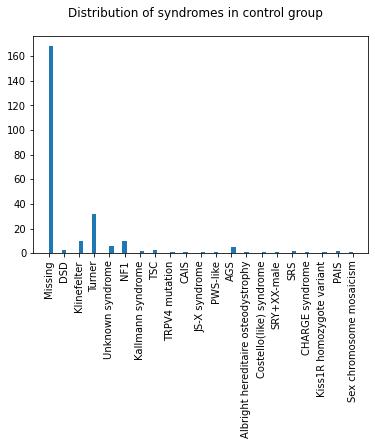

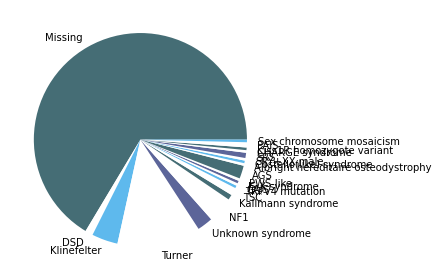

Syndrome distribution in control group:
Missing:168
DSD:3
Klinefelter:10
Turner:32
Unknown syndrome:6
NF1:10
Kallmann syndrome:2
TSC:3
TRPV4 mutation:1
CAIS:1
JS-X syndrome:1
PWS-like:1
AGS:5
Albright hereditaire osteodystrophy:1
Costello(like) syndrome:1
SRY+XX-male:1
SRS:2
CHARGE syndrome:1
Kiss1R homozygote variant:1
PAIS:2
Sex chromosome mosaicism:1


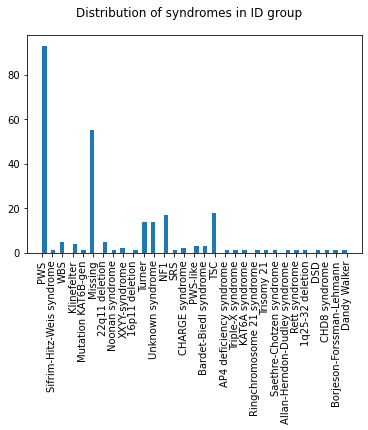

Syndrome distribution in ID group:
PWS:93
Sifrim-Hitz-Weis syndrome:1
WBS:5
Klinefelter:4
Mutation KAT6B-gen:1
Missing:55
22q11 deletion:5
Noonan syndrome:1
XXYY-syndrome:2
16p11 deletion:1
Turner:14
Unknown syndrome:14
NF1:17
SRS:1
CHARGE syndrome:2
PWS-like:3
Bardet-Biedl syndrome:3
TSC:18
AP4 deficiency syndrome:1
Triple-X syndrome:1
KAT6A syndrome:1
Ringchromosome 21 syndrome:1
Trisomy 21:1
Saethre-Chotzen syndrome:1
Allan-Herndon-Dudley syndrome:1
Rett syndrome:1
1q25-32 deletion:1
DSD:1
CHD8 syndrome:1
Borjeson-Forssman-Lehmann:1
Dandy Walker:1


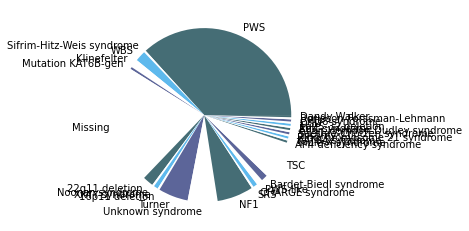

<Figure size 432x288 with 0 Axes>

In [6]:
    # Syndromen bekijken
    # print(df_syndroomcodes)
    syndromen(df_syndromen, df_control, df_1_baseline, df_syndroomcodes)